# [Title]
#### by Group 19 (Theo Marill, Finn Piney, Cecilia Xu, Hayoung Cho)

## Introduction
### Background  


### Question  
Is the experience level of players predictive of length and time of sessions?

### Data
The data of interest for this project is a player and session information of gamers using a free Minecraft server hosted and monitored by the Pacific Laboratory for Artificial Intelligence at UBC studying player behaviours to develop embodied AI. We have two `.csv` files called `players` and `sessions` with 196 and 1535 observations, respectively. 

   - The 7 player observations include:
        1. `experience` - The player's minecraft experience (Beginner, Amateur, Regular, Pro, or Veteran)
        2. `subscribe` - TRUE if they subscribe to the newsletter or FALSE otherwise
        3. `hashedEmail` - Their hashed email
        4. `played_hours` How many hours they have played on the server (hours). Data ranges from 0 to 223 hours
        5. `name` - Their in-game name
        2. `gender` - Their gender
        6. `Age` - Their age (years). Data ranges from 9 to 58 years old
   - The 5 session oberservations include:
        1. `hashedEmail` - The player's hashed email
        2. `start_time` - The start time (human readable date and time). First session was on May 1st of 2024
        3. `end_time` - The end time (human readable date and time). Last session was on August 31st of 20
        2. `original_start_time` - The start time (Unix timestamp)
        4. `original_end_time` - The end time (Unix timestamp)

## Methods and Results
First we load our packages and data:

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)
raw_players <- read_csv('https://raw.githubusercontent.com/Booch58/Group-project/refs/heads/main/players.csv')
raw_sessions <- read_csv('https://raw.githubusercontent.com/Booch58/Group-project/00c60a22e9797c412a49e2a2ebd63c1701cc9f87/sessions.csv')
raw_players
raw_sessions

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


#### Tidying

Let's standardize the column naming as well as separate the start/end *date* and the *time* of `start_time`/`end_time`.

In [2]:
players <- raw_players |>
    rename(hashed_email = hashedEmail, age = Age)|>
    mutate(experience = as_factor(experience), gender = as_factor(gender), hashed_email = fct_reorder(hashed_email, played_hours, .fun = sum))
sessions <- raw_sessions |>
    rename(hashed_email = hashedEmail) |>
    separate(col = start_time, into = c('start_date', 'start_time'), sep = " ")|>
    separate(col = start_time, into = c('start_hr', 'start_m'), sep = ":") |>
    mutate(start_time = as.double(start_hr) * 60 + as.double(start_m)) |>
    separate(col = end_time, into = c('end_date', 'end_time'), sep = " ")|>
    separate(col = end_time, into = c('end_hr', 'end_m'), sep = ":") |>
    mutate(end_time = as.double(end_hr) * 60 + as.double(end_m)) |>
    select(-start_hr, -start_m, -end_hr, -end_m)
players
sessions

experience,subscribe,hashed_email,played_hours,name,gender,age
<fct>,<lgl>,<fct>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashed_email,start_date,end_date,original_start_time,original_end_time,start_time,end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024,30/06/2024,1.71977e+12,1.71977e+12,1092,1104
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024,17/06/2024,1.71867e+12,1.71867e+12,1413,1426
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024,25/07/2024,1.72193e+12,1.72193e+12,1054,1077
⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024,28/07/2024,1.72218e+12,1.72218e+12,936,957
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024,25/07/2024,1.72189e+12,1.72189e+12,375,382
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024,20/05/2024,1.71617e+12,1.71617e+12,146,165


Here, to account for the fact that some sessions will span the midnight mark, we adjust the endtime to be **minutes past the midnight most recently before the start_time.**

In [4]:
sessions_mid <- sessions |>
    filter(end_date != start_date) |>
    mutate(end_time = end_time + 1440)

sessions_day <- sessions |>
    filter(end_date == start_date)

sessions_adj <- sessions_mid |>
    bind_rows(sessions_day)

sessions_adj

hashed_email,start_date,end_date,original_start_time,original_end_time,start_time,end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,12/05/2024,13/05/2024,1.71556e+12,1.71556e+12,1403,1454
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,29/06/2024,30/06/2024,1.71970e+12,1.71971e+12,1286,1440
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,27/07/2024,28/07/2024,1.72212e+12,1.72213e+12,1410,1463
⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024,28/07/2024,1.72218e+12,1.72218e+12,936,957
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024,25/07/2024,1.72189e+12,1.72189e+12,375,382
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024,20/05/2024,1.71617e+12,1.71617e+12,146,165


### Summary of Relevant Data
Here we have: 

1. Calculated the mean session length for each experience level.
2. Given counts of all players according to experience level and who have contributed to the sessions data.
3. Made histograms identifying count of start times for each experience level (Notice varying scales across experience levels! This is done to make less populated experience levels more visible).

In [63]:
named_sessions <- sessions_adj |>
    merge(players)

lengths <- named_sessions |>
    mutate(length = end_time - start_time) |>
    select(length, experience) |>
    group_by(experience) |>
    summarize(mean_session_length = mean(length))

populations <- named_sessions |>
    group_by(experience) |>
    summarize(count = n()) |>
    select(experience, count)


start_grid <- named_sessions |>
    ggplot(aes(x=start_time, fill = factor(experience, levels = c("Beginner","Amateur","Regular","Pro","Veteran")))) +
        geom_histogram(binwidth = 120) +
        facet_grid(rows = vars(experience), scale = "free_y") +
        labs(x="Session Start Time \n(mins past 00:00)",
             y="Count", 
             fill="Player Experience Level") +
        theme(text = element_text(size = 20))


**fig. 1**

In [64]:
lengths

experience,mean_session_length
<fct>,<dbl>
Pro,62.58974
Veteran,42.64706
Amateur,33.02198
Regular,83.34363
Beginner,29.55660


**fig. 2**

In [65]:
populations

experience,count
<fct>,<int>
Pro,39
Veteran,51
Amateur,819
Regular,518
Beginner,106


**fig. 3**

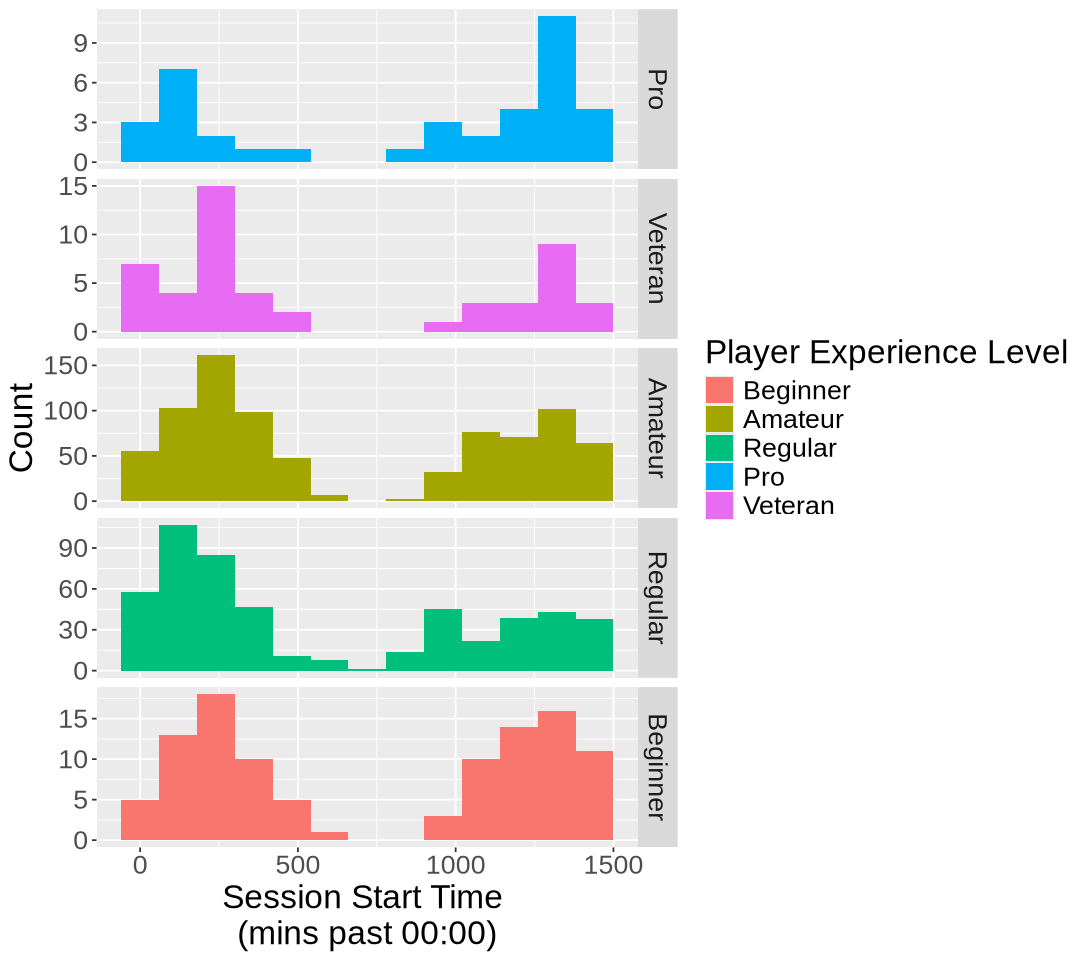

In [66]:
start_grid

### Visualization for Analysis

In [67]:
# run this cell
options(repr.plot.width = 9, repr.plot.height = 8)

start_vs_end <- ggplot(named_sessions, aes(x=start_time, y=end_time, colour = factor(experience, levels = c("Beginner","Amateur","Regular","Pro","Veteran")))) +
    geom_point(alpha = 0.4) +
    labs(title="Start and End Times of Individual Sessions \nat Different Experience Levels",
         x="Start Time (mins past 00:00)",
         y="End Time (mins past 00:00)",
         colour="Experience") +
    xlim(0,1500) +
    theme(text = element_text(size = 20)) +
    scale_color_brewer(palette = "Dark2")

____
Here we have visualized each player's sessions as a point on this graph where its start end time is on plotted on the x and y axes. Each point is also coloured according the player's experience. Interpreting the straight line, we make out that all points on the line of y = x are sessions that lasted 0 minutes and every point progressively higher above the line is a progressively longer session.  

**fig. 4**

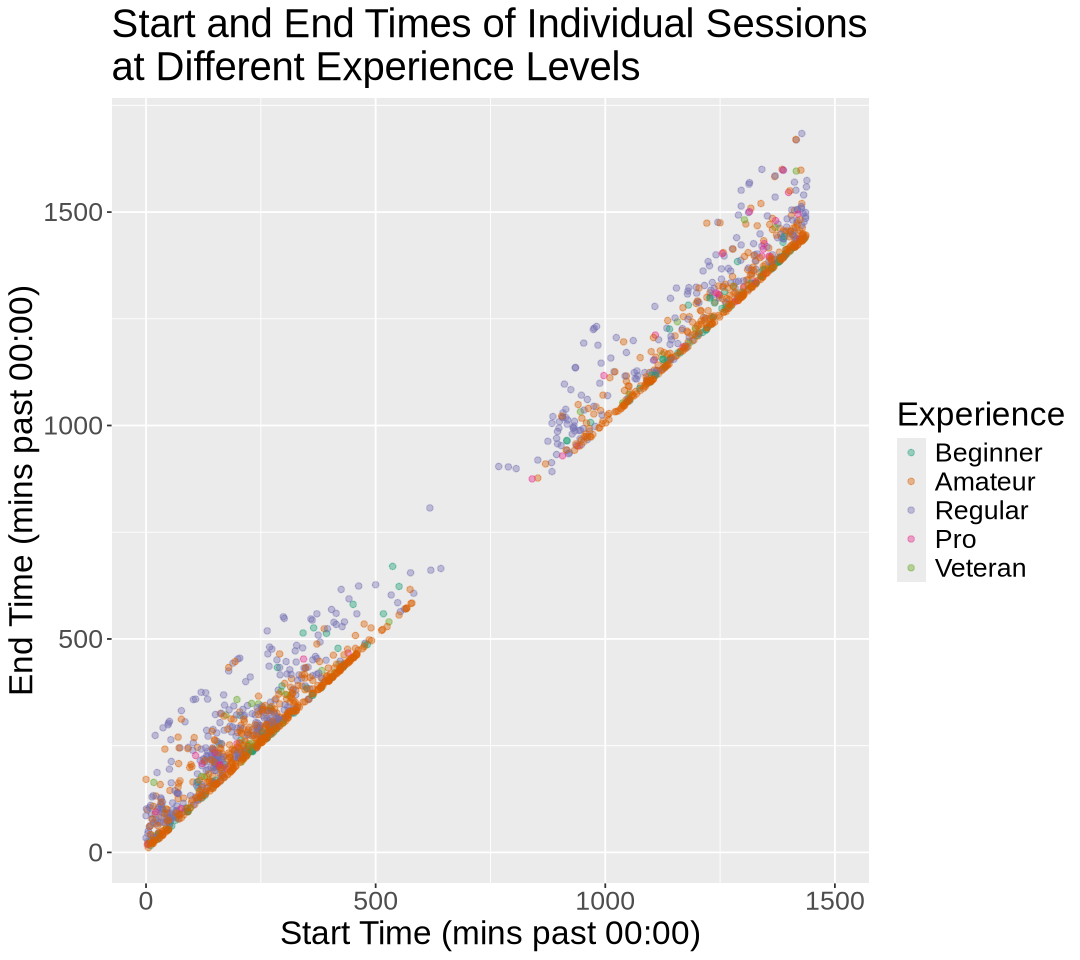

In [68]:
start_vs_end

____
### Data Analysis

In [69]:
set.seed(1122)
named_split <- initial_split(named_sessions, 0.60)
named_training <- training(named_split)
named_testing <- testing(named_split)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))
named_vfold <- vfold_cv(named_training, v = 10, strata = experience)

named_recipe <- recipe(experience ~ start_time + end_time, data = named_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())
named_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode("classification")
named_fit <- workflow() |>
    add_recipe(named_recipe) |>
    add_model(named_spec) |>
    tune_grid(resamples = named_vfold, grid = k_vals) |>
    collect_metrics()

In [70]:
k_plot <- named_fit |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x=neighbors,y=mean)) +
        geom_point() +
        geom_line() +
        labs(x="k-Neighbours",
             y="Accuracy (%)")

____
Here we found that the best K value of neighbours was around 21:

**fig. 5**

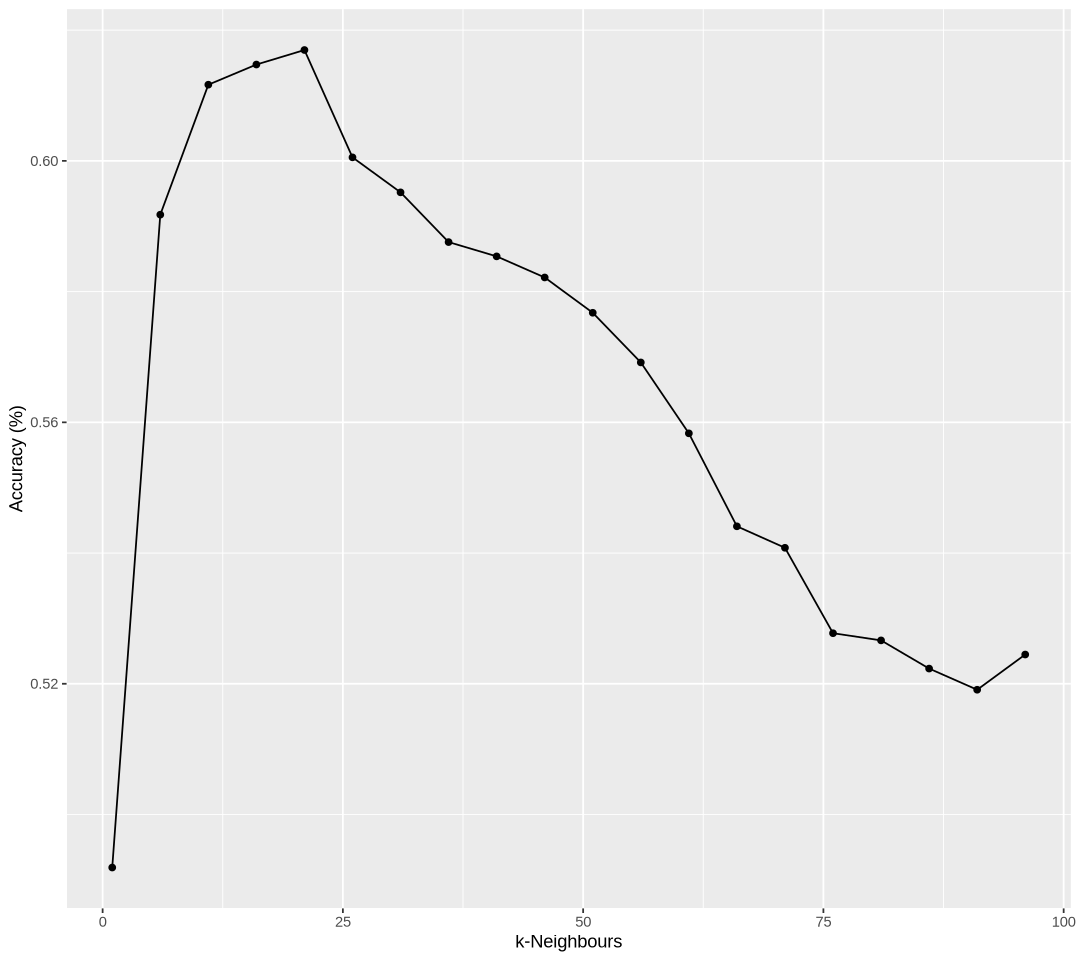

In [75]:
k_plot

____

In [72]:
named_tuned <- nearest_neighbor(weight_fun = "rectangular", neighbors = 21) |>
                    set_engine("kknn") |>
                    set_mode("classification")
named_fit2 <- workflow() |>
    add_recipe(named_recipe) |>
    add_model(named_tuned) |>
    fit(data = named_training)

named_evaluation <- named_fit2 |>
    predict(named_testing) |>
    bind_cols(named_testing) 

accuracy <- named_evaluation |>
    metrics(truth = experience, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(-.estimator)

conf <- named_evaluation |>
    conf_mat(truth = experience, estimate = .pred_class)

After creating our final analysis workflow, our accuracy on the testing data we set aside. was:

In [73]:
pull(accuracy)

[1] 0.6416938

____

Here is also the confusion matrix indicating the number of predictions compared to the true observations:

**fig. 6**

In [74]:
conf

          Truth
Prediction Pro Veteran Amateur Regular Beginner
  Pro        0       0       0       0        0
  Veteran    0       0       0       0        0
  Amateur   11      15     276      93       33
  Regular    3       2      58     118        5
  Beginner   0       0       0       0        0

____

## Discussion

<p>points to hit:
summarize what you found
discuss whether this is what you expected to find
discuss what impact could such findings have
discuss what future questions could this lead to</p>

<p>(Summarize what we found). Through our methods, we sought to explore whether the players' self-reported experience level is predictive of (1) the length of time they play and (2) the time of their sessions. The results show that ____ </p>

<p>(Discuss if this was expected). These results are _____ to what we expected. Before conducting our analysis, we predicted that higher reported experience levels should be predictive of longer session lengths in this dataset. Intuitively, we felt that this would make sense as more experienced players have a higher level of dedication to Minecraft, and would therefore play more hours. </p>

<p>(Discuss what impact could such findings have). Our methods tried to see if knowing the experience levels of players could be predictive of longer sessions to investigate which 'kind' of player would likely contribute larger amounts of data. Based on our findings, we believe that players of ____ level tend to play longer amounts, resulting in a larger amount of data collected by the research team. This helps the research team and can impact their recruiting methods as they will be able to allocate their resources in targeting ____ players, such as by _____ or ______. </p>